In [ ]:
# ====== Setup Cell ======
# Install extra libraries (only needed once)
!pip install scikit-image seaborn matplotlib

# Mount Google Drive (uncomment if dataset is in Drive)
#from google.colab import drive
#drive.mount('/content/drive')

# Upload dataset zip file (if not using Drive)
from google.colab import files
uploaded = files.upload()

# If uploaded, unzip it (adjust filename if needed)
!unzip dataset.zip -d dataset

print("✅ Setup complete.")

Saving dataset_split.zip to dataset_split.zip
unzip:  cannot find or open dataset.zip, dataset.zip.zip or dataset.zip.ZIP.
✅ Setup complete. Now run Block 1 (LBP Feature Extraction).


In [ ]:
import os

# List all files in current directory
print(os.listdir())

# Pick the correct zip file name from the list

['.config', 'dataset_split.zip', 'sample_data']


In [ ]:
import zipfile
import os

zip_path = "dataset_split.zip"  # use the correct file

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(".")

# Check folder structure
print(os.listdir("dataset_split"))

['train', 'test']


In [ ]:
#_________________________________PREPROCESSING________________________________________________
import os
import cv2
import numpy as np

# -------------------------------
# CONFIG
# -------------------------------
DATASET_DIR = "dataset_split"  # replace with your dataset root
IMG_SIZE = (128, 128)                        # resize to 138x128

def preprocess_images(folder, class_names):
    images, labels = [], []
    for label, class_name in enumerate(class_names):
        class_path = os.path.join(folder, class_name)
        if not os.path.isdir(class_path):
            continue
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)

            # Read as grayscale
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            # Resize
            img = cv2.resize(img, IMG_SIZE)

            # Normalize [0,1]
            img = img.astype("float32") / 255.0

            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

# -------------------------------
# MAIN (Preprocessing)
# -------------------------------
train_dir = os.path.join(DATASET_DIR, "train")
test_dir = os.path.join(DATASET_DIR, "test")

class_names = sorted(os.listdir(train_dir))

# Preprocess train & test
X_train, y_train = preprocess_images(train_dir, class_names)
X_test, y_test = preprocess_images(test_dir, class_names)

# Save preprocessed data
np.savez_compressed("preprocessed_dataset.npz",
                    X_train=X_train, y_train=y_train,
                    X_test=X_test, y_test=y_test,
                    class_names=class_names)

print("✅ Preprocessing complete")
print("Train set:", X_train.shape, y_train.shape)
print("Test set :", X_test.shape, y_test.shape)
print("Classes  :", class_names)

✅ Preprocessing complete
Train set: (2049, 128, 128) (2049,)
Test set : (515, 128, 128) (515,)
Classes  : ['African elephant', 'Egyptian cat', 'German shepherd', 'Labrador retriever', 'dragonfly', 'golden retriever', 'gorilla', 'koala', 'monarch', 'peacock', 'rose', 'sports car']


Train: (2049, 128, 128) (2049,)
Test : (515, 128, 128) (515,)
Classes: ['African elephant' 'Egyptian cat' 'German shepherd' 'Labrador retriever'
 'dragonfly' 'golden retriever' 'gorilla' 'koala' 'monarch' 'peacock'
 'rose' 'sports car']


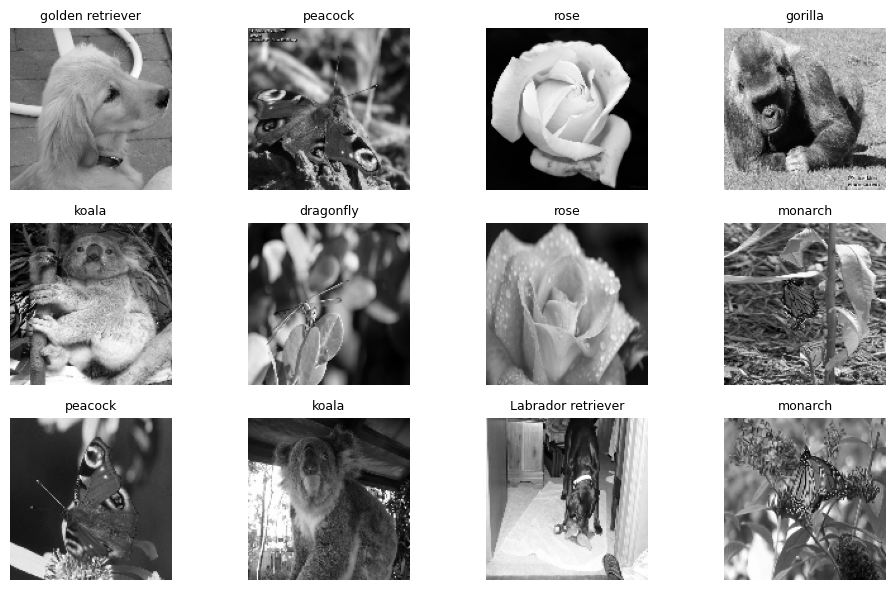

In [ ]:
#_____________________________VISUALIZATION OF PREPROCCESSED DATA____________________________________________________________
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# LOAD PREPROCESSED DATA
# -------------------------------
data = np.load("preprocessed_dataset.npz", allow_pickle=True)

X_train, y_train = data["X_train"], data["y_train"]
X_test, y_test = data["X_test"], data["y_test"]
class_names = data["class_names"]

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)
print("Classes:", class_names)

# -------------------------------
# VISUALIZE SOME IMAGES
# -------------------------------
plt.figure(figsize=(10, 6))

for i in range(12):  # show 12 random images
    idx = np.random.randint(0, X_train.shape[0])
    img = X_train[idx].squeeze()  # remove channel dim
    label = class_names[y_train[idx]]

    plt.subplot(3, 4, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(label, fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
#!/usr/bin/env python3
import numpy as np
from skimage.feature import hog
from tqdm import tqdm

# Paths
DATA_PATH = "preprocessed_dataset.npz"
OUTPUT_PATH = "hog_features.npz"

# Load preprocessed dataset
data = np.load(DATA_PATH)
X_train, y_train = data["X_train"], data["y_train"]
X_test, y_test = data["X_test"], data["y_test"]

print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Test : {X_test.shape}, {y_test.shape}")

# Optimized HOG parameters
hog_params = {
    "orientations": 9,            # typical HOG setting (good balance of detail)
    "pixels_per_cell": (8, 8),    # each cell is 8x8 pixels
    "cells_per_block": (2, 2),    # normalization over 2x2 cells
    "block_norm": "L2-Hys",       # common choice
    "transform_sqrt": True,       # better illumination invariance
    "feature_vector": True
}

def extract_hog_features(images):
    features = []
    for img in tqdm(images, desc="Extracting HOG"):
        img = img.squeeze()  # remove channel dimension (128x128)
        feat = hog(img, **hog_params)
        features.append(feat)
    return np.array(features)

# Extract features
X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

print(f"HOG Train features: {X_train_hog.shape}")
print(f"HOG Test features : {X_test_hog.shape}")

# Save features
np.savez_compressed(
    OUTPUT_PATH,
    X_train=X_train_hog, y_train=y_train,
    X_test=X_test_hog, y_test=y_test
)

print(f"✅ HOG features saved to {OUTPUT_PATH}")


Train: (2049, 128, 128), (2049,)
Test : (515, 128, 128), (515,)


Extracting HOG: 100%|██████████| 515/515 [00:04<00:00, 127.36it/s]


HOG Train features: (2049, 8100)
HOG Test features : (515, 8100)
✅ HOG features saved to hog_features.npz


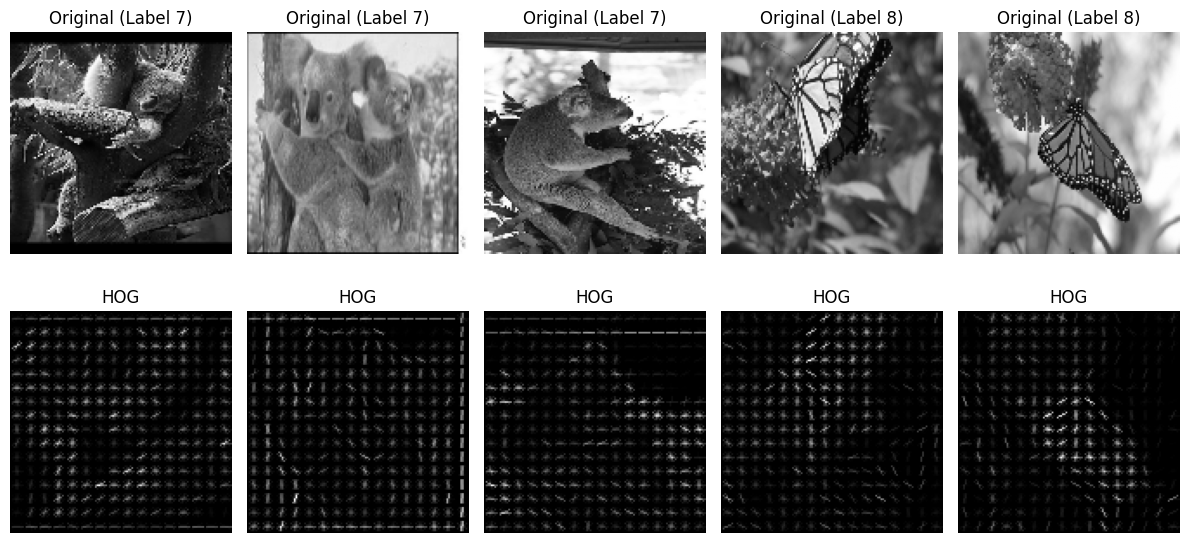

In [ ]:
#!/usr/bin/env python3
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure

# Load preprocessed dataset (before HOG extraction)
data = np.load("preprocessed_dataset.npz")
X_train, y_train = data["X_train"], data["y_train"]

# HOG parameters (same as extraction script)
hog_params = {
    "orientations": 9,
    "pixels_per_cell": (8, 8),
    "cells_per_block": (2, 2),
    "block_norm": "L2-Hys",
    "transform_sqrt": True,
    "feature_vector": True
}

# Pick some sample images
num_samples = 5
indices = np.random.choice(len(X_train), num_samples, replace=False)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(indices, 1):
    img = X_train[idx].squeeze()

    # Extract HOG + visualization
    feat, hog_image = hog(img, visualize=True, **hog_params)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # Plot original
    plt.subplot(2, num_samples, i)
    plt.imshow(img, cmap="gray")
    plt.title(f"Original (Label {y_train[idx]})")
    plt.axis("off")

    # Plot HOG
    plt.subplot(2, num_samples, i + num_samples)
    plt.imshow(hog_image_rescaled, cmap="gray")
    plt.title("HOG")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
#!/usr/bin/env python3
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score,
    confusion_matrix, classification_report, roc_curve, auc,
    matthews_corrcoef, log_loss
)
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# -------------------------------
# Setup results folder
# -------------------------------
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# -------------------------------
# Load HOG features
# -------------------------------
data = np.load("hog_features.npz")
X_train, y_train = data["X_train"], data["y_train"]
X_test, y_test = data["X_test"], data["y_test"]

print(f"Train features: {X_train.shape}, Labels: {y_train.shape}")
print(f"Test  features: {X_test.shape}, Labels: {y_test.shape}")

# -------------------------------
# Define classifiers
# -------------------------------
classifiers = {
    "Logistic_Regression": LogisticRegression(max_iter=500, solver="saga"),
    "Random_Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=25),
    "Decision_Tree": DecisionTreeClassifier(random_state=42)
}

# -------------------------------
# Train & Evaluate
# -------------------------------
for name, clf in classifiers.items():
    print(f"\n🔹 Training {name}...")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    precision = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    mcc = matthews_corrcoef(y_test, y_pred)

    # Log Loss (only if probabilities are available)
    logloss_val = None
    if hasattr(clf, "predict_proba"):
        try:
            y_proba = clf.predict_proba(X_test)
            logloss_val = log_loss(y_test, y_proba, labels=np.unique(y_train))
        except Exception as e:
            print(f"⚠️ Log Loss not available for {name}: {e}")

    print(f"✅ {name} Results:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"MCC      : {mcc:.4f}")
    if logloss_val is not None:
        print(f"Log Loss : {logloss_val:.4f}")

    # Save class-wise report
    report = classification_report(y_test, y_pred, zero_division=0)
    with open(os.path.join(RESULTS_DIR, f"{name}_report.txt"), "w") as f:
        f.write(f"{name} Results\n")
        f.write(f"Accuracy : {acc:.4f}\n")
        f.write(f"Precision: {precision:.4f}\n")
        f.write(f"Recall   : {recall:.4f}\n")
        f.write(f"F1 Score : {f1:.4f}\n")
        f.write(f"MCC      : {mcc:.4f}\n")
        if logloss_val is not None:
            f.write(f"Log Loss : {logloss_val:.4f}\n\n")
        f.write(report)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(os.path.join(RESULTS_DIR, f"{name}_confusion_matrix.png"))
    plt.close()

    # ROC Curve (One-vs-Rest for multi-class)
    y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
    n_classes = y_test_bin.shape[1]

    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_test)
        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], lw=2, label=f"Class {i} (AUC={roc_auc[i]:.2f})")
        plt.plot([0, 1], [0, 1], "k--", lw=2)
        plt.title(f"{name} - ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right", fontsize=8)
        plt.savefig(os.path.join(RESULTS_DIR, f"{name}_roc_curve.png"))
        plt.close()

print("\n📁 All results saved in 'results/' folder.")

Train features: (2049, 8100), Labels: (2049,)
Test  features: (515, 8100), Labels: (515,)

🔹 Training Logistic_Regression...
✅ Logistic_Regression Results:
Accuracy : 0.4078
Precision: 0.3917
Recall   : 0.4078
F1 Score : 0.3898
MCC      : 0.3389
Log Loss : 2.1094

🔹 Training Random_Forest...
✅ Random_Forest Results:
Accuracy : 0.3262
Precision: 0.3021
Recall   : 0.3262
F1 Score : 0.2646
MCC      : 0.2451
Log Loss : 2.1927

🔹 Training KNN...
✅ KNN Results:
Accuracy : 0.1417
Precision: 0.1186
Recall   : 0.1417
F1 Score : 0.0913
MCC      : 0.0474
Log Loss : 8.7982

🔹 Training Decision_Tree...
✅ Decision_Tree Results:
Accuracy : 0.2058
Precision: 0.2014
Recall   : 0.2058
F1 Score : 0.2020
MCC      : 0.1172
Log Loss : 28.5581

📁 All results saved in 'results/' folder.
